#  TensorFlow Distributed Training Options 

Sometimes it makes sense to perform training on a single machine. For large datasets, however, it may be necessary to perform distributed training on a cluster of multiple machines. Cluster managment often is a pain point in the machine learning pipeline. Fortunately, Amazon SageMaker makes it easy to run distributed training without having to manage cluster setup and tear down. In this notebook, we'll examine some different options for performing distributed training with TensorFlow in Amazon SageMaker. In particular, we'll look at the following options:

- **Parameter Servers**: processes that receive asynchronous updates from worker nodes and distribute updated gradients to all workers.

- **Horovod**:  a framework based on Ring-AllReduce wherein worker nodes synchronously exchange gradient updates only with two other workers at a time.  

The model used for this notebook is a basic Convolutional Neural Network (CNN) based on [the Keras examples](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py), although we will be using the tf.keras implementation of Keras rather than the separate Keras reference implementation.  We'll train the CNN to classify images using the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), a well-known computer vision dataset. It consists of 60,000 32x32 images belonging to 10 different classes, with 6,000 images per class. Here is a graphic of the classes in the dataset, as well as 10 random images from each:

![cifar10](https://maet3608.github.io/nuts-ml/_images/cifar10.png)


## Setup 

We'll begin with some necessary imports, and get an Amazon SageMaker session to help perform certain tasks, as well as an IAM role with the necessary permissions.

In [21]:
%matplotlib inline
import numpy as np
import os
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/DEMO-tf-distribution-options'
print('Bucket:\n{}'.format(bucket))

Bucket:
sagemaker-us-west-2-386258261521


Now we'll run a script that fetches the dataset and converts it to the TFRecord format, which provides several conveniences for training models in TensorFlow.

In [22]:
!wget -q https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-script-mode/master/tf-distribution-options/generate_cifar10_tfrecords.py
!python generate_cifar10_tfrecords.py --data-dir ./data

W1007 22:45:13.527844 140575061022528 deprecation_wrapper.py:119] From generate_cifar10_tfrecords.py:35: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W1007 22:45:13.528081 140575061022528 deprecation_wrapper.py:119] From generate_cifar10_tfrecords.py:35: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.

Download from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and extract.
Successfully downloaded cifar-10-python.tar.gz 170498071 bytes.
Generating ./data/train/train.tfrecords
Generating ./data/validation/validation.tfrecords
Generating ./data/eval/eval.tfrecords
Done!


For Amazon SageMaker hosted training on a cluster separate from this notebook instance, training data must be stored in Amazon S3, so we'll upload the data to S3 now.

In [23]:
inputs = sagemaker_session.upload_data(path='data', key_prefix='data/tf-distribution-options')
display(inputs)

's3://sagemaker-us-west-2-386258261521/data/tf-distribution-options'

## Distributed Training with Horovod

Horovod is an open source distributed training framework for TensorFlow, Keras, PyTorch, and MXNet. It is an alternative to the more "traditional" parameter servers method of performing distributed training demonstrated above.  Horovod can be more performant than parameter servers in large, GPU-based clusters where large models are trained. In Amazon SageMaker, Horovod is only available with TensorFlow version 1.12 or newer. 

Only a few lines of code are necessary to use Horovod for distributed training of a Keras model defined by the tf.keras API.  For details, see the `train_hvd.py` script included with this notebook; the changes primarily relate to:

- importing Horovod.
- initializing Horovod.
- configuring GPU options and setting a Keras/tf.session with those options.

The Estimator object for Horovod training is very similar to the parameter servers Estimator above, except we specify a `distributions` parameter describing Horovod attributes such as the number of process per host, which is set here to the number of GPUs per machine.  Beyond these few simple parameters and the few lines of code in the training script, there is nothing else you need to do to use distributed training with Horovod; Amazon SageMaker handles the heavy lifting for you and manages the underlying cluster setup.

In [24]:
from sagemaker.tensorflow import TensorFlow

git_config = {'repo': 'https://github.com/aws-samples/amazon-sagemaker-script-mode', 
              'branch': 'master'}

hvd_instance_type = 'ml.p3.2xlarge'
hvd_processes_per_host = 1
hvd_instance_count = 2

distributions = {'mpi': {
                    'enabled': True,
                    'processes_per_host': hvd_processes_per_host,
                    'custom_mpi_options': '-verbose --NCCL_DEBUG=INFO -x OMPI_MCA_btl_vader_single_copy_mechanism=none'
                        }
                }

hyperparameters = {'epochs': 60, 'batch-size' : 256}

estimator_hvd = TensorFlow(
                       git_config=git_config,
                       source_dir='tf-distribution-options/code',
                       entry_point='train_hvd.py',
                       base_job_name='hvd-cifar10-tf', 
                       role=role,
                       framework_version='1.13',
                       py_version='py3',
                       hyperparameters=hyperparameters,
                       train_instance_count=hvd_instance_count, 
                       train_instance_type=hvd_instance_type,
                       tags = [{'Key' : 'Project', 'Value' : 'cifar10'},{'Key' : 'TensorBoard', 'Value' : 'dist'}],
                       distributions=distributions)

With these changes to the Estimator, we can call its `fit` method to start training. After training completes, the tf.keras model will be saved in the SavedModel .pb format so it can be served by a TensorFlow Serving container.  Note that the model is only saved by the the master, Horovod rank = 0 process (once again disregard any warnings about the model not being saved by all the processes).

In [25]:
remote_inputs = {'train' : inputs+'/train', 'validation' : inputs+'/validation', 'eval' : inputs+'/eval'}
estimator_hvd.fit(remote_inputs, wait=True)

2019-10-07 22:47:40 Starting - Starting the training job...
2019-10-07 22:47:45 Starting - Launching requested ML instances......
2019-10-07 22:49:11 Starting - Preparing the instances for training......
2019-10-07 22:50:03 Downloading - Downloading input data...
2019-10-07 22:50:13 Training - Downloading the training image...
2019-10-07 22:50:58 Training - Training image download completed. Training in progress.2019-10-07 22:50:57,387 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-10-07 22:51:00,721 sagemaker-containers INFO     Starting MPI run as worker node.
2019-10-07 22:51:00,721 sagemaker-containers INFO     Creating SSH daemon.
2019-10-07 22:51:00,726 sagemaker-containers INFO     Waiting for MPI workers to establish their SSH connections
2019-10-07 22:51:00,728 sagemaker-containers INFO     Cannot connect to host algo-2
2019-10-07 22:51:00,728 sagemaker-containers INFO     Connection failed with exception: 
 [Errno None] Unable to

[ip-10-0-103-12.us-west-2.compute.internal:00047] 1 more process has sent help message help-orte-rmaps-base.txt / rmaps:membind-not-supported
[ip-10-0-103-12.us-west-2.compute.internal:00047] Set MCA parameter "orte_base_help_aggregate" to 0 to see all help / error messages
[1,1]<stdout>:Epoch 1/60
[1,0]<stdout>:Epoch 1/60
[1,1]<stderr>:2019-10-07 22:51:14.075173: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally
[1,0]<stdout>:algo-1:53:77 [0] NCCL INFO NET/Socket : Using [0]eth0:10.0.103.12<0>
[1,0]<stdout>:algo-1:53:77 [0] NCCL INFO NET/Plugin : No plugin found (libnccl-net.so).
[1,0]<stdout>:
[1,0]<stdout>:algo-1:53:77 [0] misc/ibvwrap.cc:63 NCCL WARN Failed to open libibverbs.so[.1]
[1,0]<stdout>:NCCL version 2.4.7+cuda10.0
[1,1]<stdout>:algo-2:60:84 [0] NCCL INFO NET/Socket : Using [0]eth0:10.0.85.207<0>
[1,1]<stdout>:algo-2:60:84 [0] NCCL INFO NET/Plugin : No plugin found (libnccl-net.so).
[1,1]<stdout>:
[1,1]<stdout>:algo-

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:58/78 [=====================>........] - ETA: 1s - loss: 1.6515 - acc: 0.3774[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:59/78 [=====================>........] - ETA: 1s - loss: 1.6489 - acc: 0.3790[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:78/78 [==============================] - 5s 59ms/step - loss: 1.4196 - acc: 0.4819 - val_loss: 1.7670 - val_acc: 0.3785
[1,0]<stdout>:Epoch 4/60
[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 4s - loss: 1.4755 - acc: 0.4961[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 21s - loss: 1.2733 - acc: 0.5586[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#0

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 1.1059 - acc: 0.5820[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 17s - loss: 1.2489 - acc: 0.5625[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 1.0748 - acc: 0.6081[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>............

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 4s - loss: 0.8846 - acc: 0.6914[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 27s - loss: 0.9727 - acc: 0.6523[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 2/78 [..............................] - ETA: 15s - loss: 0.9748 - acc: 0.6445[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 2/78 [............

[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 20s - loss: 0.7715 - acc: 0.6914[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 4s - loss: 0.8872 - acc: 0.6875[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 2/78 [..............................] - ETA: 12s - loss: 0.8495 - acc: 0.6797[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 2/78 [............

[1,1]<stdout>:#015[1,0]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 18s - loss: 0.6843 - acc: 0.7305[1,0]<stdout>: 1/78 [..............................] - ETA: 4s - loss: 0.7747 - acc: 0.7617[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 2/78 [..............................] - ETA: 10s - loss: 0.7417 - acc: 0.7246[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>...........

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:67/78 [========================>.....] - ETA: 0s - loss: 0.7460 - acc: 0.7406[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:67/78 [========================>.....] - ETA: 0s - loss: 0.7402 - acc: 0.7449[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:69/78 [=========================>...

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.7570 - acc: 0.7422[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 19s - loss: 0.7694 - acc: 0.7383[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 2/78 [..............................] - ETA: 3s - loss: 0.6966 - acc: 0.7539[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 2/78 [.............

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.6892 - acc: 0.7812[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 18s - loss: 0.6387 - acc: 0.7773[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>.............................] - ETA: 8s - loss: 0.6829 - acc: 0.7695 [1,0]<stdout>: 3/78 [>...........

[1,0]<stdout>:#015[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 18s - loss: 0.6429 - acc: 0.7656[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.6183 - acc: 0.7734[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 0.6735 - acc: 0.7630[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>............

[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:78/78 [==============================] - 5s 60ms/step - loss: 0.6229 - acc: 0.7875 - val_loss: 0.6060 - val_acc: 0.7878
[1,0]<stdout>:Epoch 24/60
[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 4s - loss: 0.5842 - acc: 0.8008[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 23s - loss: 0.5902 - acc: 0.8125[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:69/78 [=========================>....] - ETA: 0s - loss: 0.5685 - acc: 0.8015[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:69/78 [=========================>....] - ETA: 0s - loss: 0.5882 - acc: 0.7963[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:70/78 [=========================>...

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:73/78 [===========================>..] - ETA: 0s - loss: 0.5620 - acc: 0.8066[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:75/78 [===========================>..] - ETA: 0s - loss: 0.5703 - acc: 0.8037[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:75/78 [===========================>.

[1,0]<stdout>:#015[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 19s - loss: 0.5499 - acc: 0.8086[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.5890 - acc: 0.7930[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 0.5386 - acc: 0.8164[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>............

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:70/78 [=========================>....] - ETA: 0s - loss: 0.5362 - acc: 0.8140[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:71/78 [==========================>...] - ETA: 0s - loss: 0.5368 - acc: 0.8149[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:71/78 [==========================>...] - ETA

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 4s - loss: 0.5390 - acc: 0.8125[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 16s - loss: 0.4349 - acc: 0.8203[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 2/78 [..............................] - ETA: 4s - loss: 0.5404 - acc: 0.8008[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 2/78 [.............

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:75/78 [===========================>..] - ETA: 0s - loss: 0.5052 - acc: 0.8284[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:76/78 [============================>.] - ETA: 0s - loss: 0.5048 - acc: 0.8285[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:76/78 [============================>

[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 18s - loss: 0.4905 - acc: 0.8398[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.5116 - acc: 0.8359[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>.............................] - ETA: 8s - loss: 0.4741 - acc: 0.8281 [1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>...........

#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:70/78 [=========================>....] - ETA: 0s - loss: 0.4774 - acc: 0.8354[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:72/78 [==========================>...] - ETA: 0s - loss: 0.4781 - acc: 0.8354[1,0]<stdout>:72/78 [==========================>...] - ETA

[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 18s - loss: 0.6156 - acc: 0.8008[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.5465 - acc: 0.8281[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 2/78 [..............................] - ETA: 3s - loss: 0.4905 - acc: 0.8340[1,1]<stdout>: 2/78 [.............

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.4433 - acc: 0.8438[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 20s - loss: 0.4266 - acc: 0.8672[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 2/78 [..............................] - ETA: 3s - loss: 0.4142 - acc: 0.8594[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 2/78 [.............

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.5499 - acc: 0.7773[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 18s - loss: 0.5002 - acc: 0.8398[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 2/78 [..............................] - ETA: 10s - loss: 0.5388 - acc: 0.8223[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 2/78 [............

[1,0]<stdout>:#015[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 14s - loss: 0.4519 - acc: 0.8477[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.4841 - acc: 0.8398[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 0.4554 - acc: 0.8411[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>............

[1,0]<stdout>:#015[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 18s - loss: 0.4837 - acc: 0.8516[1,0]<stdout>: 1/78 [..............................] - ETA: 4s - loss: 0.3665 - acc: 0.8789[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 3/78 [>.............................] - ETA: 3s - loss: 0.3664 - acc: 0.8789[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>............

[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:78/78 [==============================] - 4s 58ms/step - loss: 0.3977 - acc: 0.8642 - val_loss: 0.3889 - val_acc: 0.8678
[1,0]<stdout>:Epoch 56/60
[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.3678 - acc: 0.8867[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 17s - loss: 0.4336 - acc: 0.8594[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#

[1,0]<stdout>:#015[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.3951 - acc: 0.8633[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 19s - loss: 0.3737 - acc: 0.8555[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>: 2/78 [..............................] - ETA: 3s - loss: 0.3631 - acc: 0.8750[1,1]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,1]<stdout>: 3/78 [>............

[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#015[1,0]<stdout>:78/78 [==============================] - 5s 58ms/step - loss: 0.3918 - acc: 0.8647 - val_loss: 0.3935 - val_acc: 0.8638
[1,0]<stdout>:Epoch 60/60
[1,0]<stdout>:#015[1,1]<stdout>:#015[1,1]<stdout>: 1/78 [..............................] - ETA: 21s - loss: 0.4123 - acc: 0.8867[1,0]<stdout>: 1/78 [..............................] - ETA: 3s - loss: 0.4818 - acc: 0.8320[1,0]<stdout>:#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#010#


2019-10-07 22:56:34 Uploading - Uploading generated training model2019-10-07 22:56:32,867 sagemaker-containers INFO     MPI process finished.
2019-10-07 22:56:32,867 sagemaker_tensorflow_container.training WARNING  Your model will NOT be servable with SageMaker TensorFlow Serving container.The model artifact was not saved in the TensorFlow SavedModel directory structure:
https://www.tensorflow.org/guide/saved_model#structure_of_a_savedmodel_directory
2019-10-07 22:56:32,867 sagemaker-containers INFO     Reporting training SUCCESS

2019-10-07 22:57:05 Completed - Training job completed
Training seconds: 844
Billable seconds: 844


We can now plot training curves for the Horovod training job similar to the curves we plotted for the parameter servers training job:

After training is complete, it is always a good idea to take a look at training curves to diagnose problems, if any, during training and determine the representativeness of the training and validation datasets.  We can do this with TensorBoard, and also with the Keras API: conveniently, the Keras `fit` invocation returns a data structure with the training history. In our training script, this history is saved on the lead training node, then uploaded with the model when training is complete.

To retrieve the history, we first download the model locally, then unzip it to gain access to the history data structure. We can then simply load the history as JSON:

In [26]:
import matplotlib.pyplot as plt

def plot_training_curves(history): 
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    ax = axes[0]
    ax.plot(history['acc'], label='train')
    ax.plot(history['val_acc'], label='validation')
    ax.set(
        title='model accuracy',
        ylabel='accuracy',
        xlabel='epoch')
    ax.legend()

    ax = axes[1]
    ax.plot(history['loss'], label='train')
    ax.plot(history['val_loss'], label='validation')
    ax.set(
        title='model loss',
        ylabel='loss',
        xlabel='epoch')
    ax.legend()
    fig.tight_layout()

download: s3://sagemaker-us-west-2-386258261521/hvd-cifar10-tf-2019-10-07-22-47-39-315/output/model.tar.gz to hvd_model/model.tar.gz


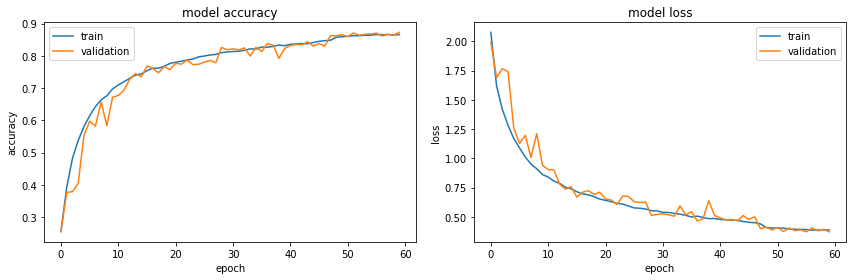

In [27]:
import json 

!aws s3 cp {estimator_hvd.model_data} ./hvd_model/model.tar.gz
!tar -xzf ./hvd_model/model.tar.gz -C ./hvd_model

with open('./hvd_model/hvd_history.p', "r") as f:
    hvd_history = json.load(f)
    
plot_training_curves(hvd_history)

## Model Deployment with Amazon Elastic Inference

Amazon SageMaker supports both real time inference and batch inference. In this notebook, we will focus on setting up an Amazon SageMaker hosted endpoint for real time inference with TensorFlow Serving (TFS).  Additionally, we will discuss why and how to use Amazon Elastic Inference with the hosted endpoint.

### Deploying the Model

When considering the overall cost of a machine learning workload, inference often is the largest part, up to 90% of the total.  If a GPU instance type is used for real time inference, it typically is not fully utilized because, unlike training, real time inference usually does not involve continuously sending large batches of data to the model.  Elastic Inference provides GPU acceleration suited for inference, allowing you to add just the right amount of inference acceleration to a hosted endpoint for a fraction of the cost of using a full GPU instance.

The `deploy` method of the Estimator object creates an endpoint which serves prediction requests in near real time.  To utilize Elastic Inference with the SageMaker TFS container, simply provide an `accelerator_type` parameter, which determines the type of accelerator that is attached to your endpoint. Refer to the **Inference Acceleration** section of the [instance types chart](https://aws.amazon.com/sagemaker/pricing/instance-types) for a listing of the supported types of accelerators. 

Here we'll use a general purpose CPU compute instance type along with an Elastic Inference accelerator:  together they are much cheaper than the smallest P3 GPU instance type.

In [ ]:
predictor = estimator_hvd.deploy(initial_instance_count=1,
                                  instance_type='ml.m5.xlarge',
                                  accelerator_type='ml.eia1.medium')

Using already existing model: hvd-cifar10-tf-2019-10-07-22-47-39-315


-------

In [38]:
predictor_wo_ei = estimator_hvd.deploy(initial_instance_count=1,
                                  instance_type='ml.p3.2xlarge')

Using already existing model: hvd-cifar10-tf-2019-10-07-22-47-39-315


-------------------------------------------------------------------------------------!

By using a general purpose CPU instance with an Elastic Inference accelerator instead of a GPU intance, substantial costs savings are achieved.  As of Q4 2019, On-Demand pricing for those resources is \\$0.269 per hour (ml.m5.xlarge), plus \\$0.182 per hour (ml.eia1.medium), for a total of \\$0.451 per hour. The total cost compared to the pricing of the smallest P3 family (NVIDIA Volta V100) GPU instance is as follows:

- Elastic Inference solution: \\$0.451 per hour
- GPU instance ml.p3.2xlarge: \\$4.284 per hour

To summarize, the Elastic Inference solution cost is about 10% of the cost of using a full P3 family GPU instance. 

###  Labels and Sample Data
  
Now that we have a Predictor object wrapping a real time Amazon SageMaker hosted enpoint, we'll define the label names and look at a sample of 10 images, one from each class.

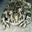

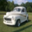

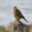

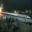

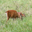

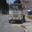

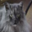

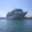

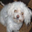

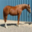

In [29]:
from IPython.display import Image, display

os.system("aws s3 cp s3://sagemaker-workshop-pdx/cifar-10-module/sample-img ./sample-img --recursive --quiet")

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

images = []
for entry in os.scandir('sample-img'):
    if entry.is_file() and entry.name.endswith("png"):
        images.append('sample-img/' + entry.name)

for image in images:
    display(Image(image))

### Pre/post-postprocessing Script

The TFS container in Amazon SageMaker by default uses the TFS REST API to serve prediction requests. This requires the input data to be converted to JSON format.  One way to do this is to create a Docker container to do the conversion, then create an overall Amazon SageMaker model that links the conversion container to the TFS container with the model. This is known as an Amazon SageMaker Inference Pipeline, as demonstrated in another [sample notebook](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/sagemaker_batch_transform/working_with_tfrecords).  

However, as a more convenient alternative for many use cases, the Amazon SageMaker TFS container provides a data pre/post-processing script feature that allows you to simply supply a data transformation script.  Using such a script, there is no need to build containers or directly work with Docker.  The simplest form of a script must only (1) implement an `input_handler` and `output_handler` interface, as shown in the code below, (2) be named `inference.py`, and (3) be placed in a `/code` directory.

In [30]:
!wget -q https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-script-mode/master/tf-distribution-options/code/inference.py
#!cat ./inference.py

On the input preprocessing side, the code takes an image read from Amazon S3 and converts it to the required TFS REST API input format.  On the output postprocessing side, the script simply passes through the predictions in the standard TFS format without modifying them. Alternatively, we could have just returned a class label for the class with the highest score, or performed other postprocessing that would be helpful to the application consuming the predictions. 

### Requirements.txt

Besides an `inference.py` script implementing the handler interface, it also may be necessary to supply a `requirements.txt` file to ensure any necessary dependencies are installed in the container along with the script.  For this script, in addition to the Python standard libraries we used the Pillow and Numpy libraries.

In [31]:
!wget -q https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-script-mode/master/tf-distribution-options/code/requirements.txt
!cat ./requirements.txt

Pillow
numpy


### Make Predictions

Next we'll set up the Predictor object created by the `deploy` method call above. Since we are using a preprocessing script, we need to specify the Predictor's content type as `application/x-image` and override the default (JSON) serializer. We can now get predictions about the sample data displayed above simply by providing the raw .png image bytes to the Predictor.  

In [39]:
predictor.content_type = 'application/x-image'
predictor.serializer = None

def get_prediction(file_path):
    
    with open(file_path, "rb") as image:
        f = image.read()
    b = bytearray(f)
    return labels[np.argmax(predictor.predict(b)['predictions'], axis=1)[0]]

In [40]:
import time
start = time.time()
predictions = [get_prediction(image) for image in images]
end = time.time()
print(end - start)
print(predictions)

11.254255533218384
['frog', 'automobile', 'bird', 'airplane', 'deer', 'truck', 'cat', 'ship', 'dog', 'horse']


# Cleanup

To avoid incurring charges due to a stray endpoint, delete the Amazon SageMaker endpoint if you no longer need it:

In [41]:
sagemaker_session.delete_endpoint(predictor.endpoint)